In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import pandas as pd
from astropy.io import ascii 
from astropy.table import Table 

In [4]:
#function for plot formatting
colors = ["#ca8ade",
"#9fdf66",
"#b7d6ff",
"#e82c22"]
def plotting( title, x_title, y_title, show = True, myfontsize=15):
    plt.xticks(fontsize=myfontsize-4)
    plt.yticks(fontsize=myfontsize-5)
    plt.title(title, fontsize= myfontsize +2)
    plt.xlabel(x_title,fontsize=myfontsize)
    plt.ylabel(y_title,fontsize=myfontsize)
    if show:
        plt.show()

In [5]:
#opening data to look and putting it into astropy Table
with open('data.dat') as f:
    content = f.readlines()
    columns = ['time', 'flux', 'fluxerr']
    data = ascii.read(content, names = columns)  


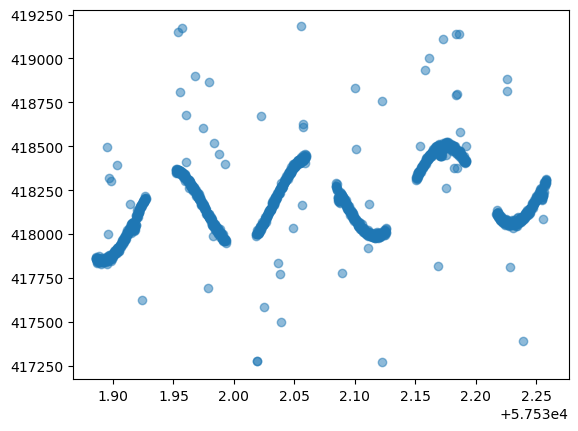

In [6]:
#plotting raw data
plt.scatter(data['time'].value, data['flux'].value, alpha = .5)

In [7]:
#known values
period_hst = 95.48 / (24 * 60)
start_time = 57531.87312
duration = 166.484 / 86400
t0 = 57531.91792371155
eclip_period = 0.08437610463121233

In [8]:
#eclipse time periods
eclip1 = np.array([t0 - duration/2, t0 + duration/2])
eclips = [eclip1 + (eclip_period * i) for i in range(7)]

#creates new column if transit = 1 than durring a transit if 0 not during a transit
data['transit'] = np.zeros(len(data))
for i in range(len(data)):
    for eclip in eclips:
        if eclip[0] <= data['time'][i] <= eclip[1]:
            data['transit'][i] = 1

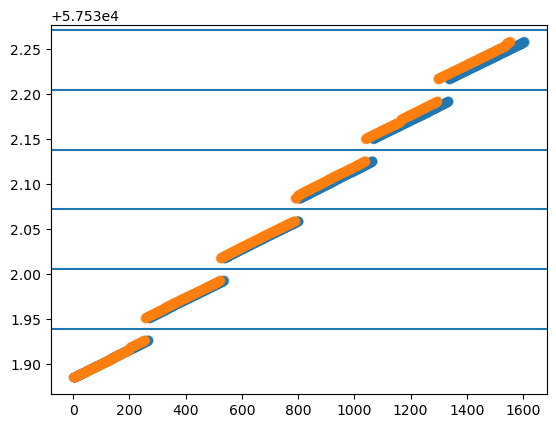

In [9]:
#looking at time jumps
plt.scatter([i for i in range(len(data))], data['time'], alpha = .5)
plt.scatter([i for i in range(len(data[data["transit"] == 0]))], data[data["transit"] == 0]["time"], alpha = .5)
for i in range(1,7):
    plt.axhline(start_time + i* period_hst)


In [10]:
#creating separate data sets per HST orbit (transits not included)
time_sectioned = [[],[],[],[],[],[]]
flux_sectioned = [[],[],[],[],[],[]]
for i in data[data["transit"] == 0.0]:
    if i['time'] < start_time + period_hst:
        time_sectioned[0].append(i['time'])
        flux_sectioned[0].append(i['flux'])
    
    elif i['time'] < start_time + 2*period_hst:
        time_sectioned[1].append(i['time'])
        flux_sectioned[1].append(i['flux'])
        
    elif i['time'] < start_time + 3*period_hst:
        time_sectioned[2].append(i['time'])
        flux_sectioned[2].append(i['flux'])
        
    elif i['time'] < start_time + 4*period_hst:
        time_sectioned[3].append(i['time'])
        flux_sectioned[3].append(i['flux'])
    
    elif i['time'] < start_time + 5*period_hst:
        time_sectioned[4].append(i['time'])
        flux_sectioned[4].append(i['flux'])
        
    else:
        time_sectioned[5].append(i['time'])
        flux_sectioned[5].append(i['flux'])

In [11]:
 
def moving_median(data_set_t, data_set_f, window=5):
    '''input: time and flux data set, optional window size
       output: moving median smoothed flux dataset and a time dataset'''
    times = np.zeros(len(data_set_f) - (window + 1))
    flux_med = np.zeros( len(data_set_f) - (window + 1))
    
    for i in range(len(data_set_f) - (window + 1)):
        flux_med[i] = np.median(data_set_f[i:i+window]) #median of window
        times[i] = np.median(data_set_t[i:i+window]) #average time 
        
    return(times, flux_med)
    
    

In [12]:
#creating median value smoothings 
#treating each section of data points as indivdual sets

u_i = []
g_i = []

window_size = 5
for i in range(len(time_sectioned)):
    times, flux_med = moving_median(time_sectioned[i], flux_sectioned[i], 
                                    window = window_size)
    u_i += list(times)
    g_i += list(flux_med)

In [13]:
'''using moving median piecewise to get interperted flux values 
   at time values in data'''
time_values = data['time'].value
interp = np.interp(time_values, u_i, g_i)

In [14]:
#marking edges of data from moving median
edges = []
for i in time_sectioned: 
    edges += i[0: int(window_size/2)]
    edges += i[-int(window_size/2):]

How I choose sigma cut off ($f$)\
assuming that the data has normally distributed error
$$
\begin{align*}
\text{probability a good data point is mistaken as an outlier} &= \frac{1}{\text{length of data}} \\
= \frac{1}{1605} &= \text{erfc}(f/ \sqrt{2}) \\
f &= 3.4
\end{align*}
$$

$$
\frac{1}{\text{# of data points}} = \frac{2}{\sqrt{π}} \int^f_0 e^{-t^2} dt
$$

In [15]:
data['edge'] = np.zeros(len(data))
data['outlier'] = np.zeros(len(data))
#creating column indicating if data is outlier or edge of moving median
sigma = 3.4   
for i in range(len(data)):
    if data[i]['transit'] == 1:
        continue
    
    elif data[i]['time'] in edges:
        #if edge of moving median (thus no correating moving median value)
        data[i]['edge'] = 1
    
    elif abs(data[i]['flux']-interp[i]) > (sigma*data[i]['fluxerr']):
        #if outside sigma cutoff
        data[i]['outlier'] = 1 
        

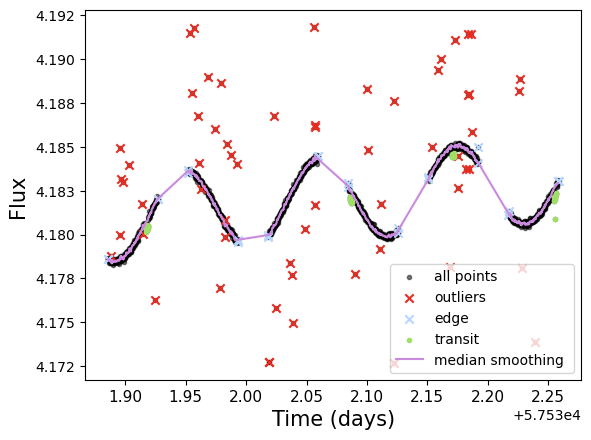

In [16]:
plt.scatter(data['time'], data['flux']  * 10**(-5), 
            marker='.', label = 'all points', color = 'k', alpha = .5)


plt.scatter(data[data['outlier'] == 1]['time'], data[data['outlier'] == 1]['flux'] * 10**(-5), 
            color = colors[3], marker = 'x', label = 'outliers')

plt.scatter(data[data['edge'] == 1]['time'], data[data['edge'] == 1]['flux'] * 10**(-5), 
            color = colors[2], marker = 'x', label = 'edge')

plt.scatter(data[data['transit'] == 1]['time'], data[data['transit'] == 1]['flux'] * 10**(-5), 
            color = colors[1], marker = '.', label = 'transit')

plt.plot(u_i, np.array(g_i)  * 10**(-5), alpha = 1, color = colors[0], label = 'median smoothing ')
plt.legend()
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.3f}'))
plotting('', 'Time (days)', 'Flux ', show = False)
plt.savefig('outliers.pdf')


In [17]:
#column indicate if data point is an outlier, transit, or edge point
data['t+e+o'] = data['transit'] + data['outlier'] + data['edge']
#column indicate if data point is an outlier or edge point
data['e+o'] = data['outlier'] + data['edge']
#creating dataset for modeling detrending data
detrending_data = data[data['t+e+o']==0]['time', 'flux', 'fluxerr'].copy()



Creating normal equations solver that solves for A, B, C, D in:

$$
   f(A, B, C, D; t) = A + Bt + C \sin(ωt) + D \cos(ωt)
$$
where $ω = \frac{2 π}{P}$ and P is the hubble period \
the normal equation for this is 
$$
\vec{β} = (\vec{x}^T \vec{x})^{-1}  (\vec{x}^T  \vec{y})
$$
where y is the flux and \
$$\vec{β} = \begin{bmatrix} A \\ B \\ C \\ D \end{bmatrix} $$
\
$$\vec{x} = \begin{bmatrix} 1 & x_1 & \sin(ω x_1) & \cos(ω x_1) \\
             \vdots & \vdots & \vdots & \vdots \\
              1 & x_n & \sin(ω x_n) & \cos(ω x_n) \end{bmatrix} $$
\
$$\vec{y} = \begin{bmatrix} y_1 \\
             \vdots \\
              y_n  \end{bmatrix} $$
              
$$ χ^2 $$

In [18]:
def normal_eq_solver(t,y, P = period_hst):
    #given t and y will return expected beta using normal function above
    ω = 2 * np.pi / P
    x = np.ones((len(t), 4))
    x[:, 1] = t
    x[:, 2] = np.sin(t * ω)
    x[:, 3] = np.cos(t * ω)
    x_T = x.transpose()
    inv_pt = np.linalg.inv(np.matmul(x_T, x))
    x_T_y = np.matmul(x_T, y)
    beta = np.matmul(inv_pt, x_T_y)
    return beta

In [19]:
def using_ABCD_to_flux(t, β, P = period_hst):
    #given a beta and t will return the expected flux by this function
    ω = 2* np.pi / P
    x = np.ones((len(t), 4))
    x[:, 1] = t
    x[:, 2] = np.sin(t * ω)
    x[:, 3] = np.cos(t * ω)
    ans = np.matmul( x, β)
    return ans

[-3.05475520e+07  5.38234863e+02 -7.39938202e+01  9.37337952e+01]


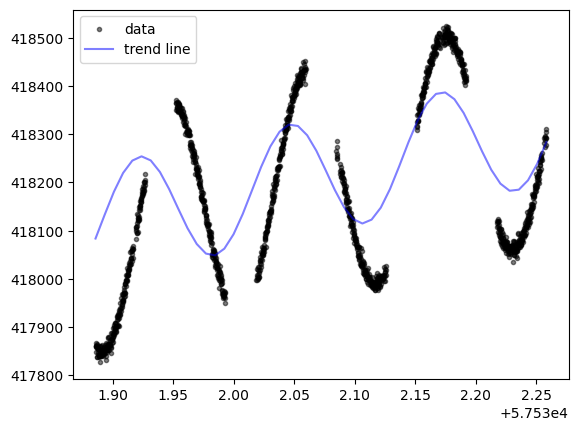

In [20]:
starting_period = (max(detrending_data['time']) - min(detrending_data['time'])) / 3

#test trial no binning 
ABCD = normal_eq_solver(detrending_data['time'].value, detrending_data['flux'].value, P = 0.2) #starting_period)
print(ABCD)
t_trend = np.linspace(min(detrending_data['time']), max(detrending_data['time']))

detrend_flux = using_ABCD_to_flux(t_trend , ABCD, starting_period)

plt.scatter(detrending_data['time'], detrending_data['flux'], color = 'k', marker = '.', 
            label = 'data', alpha =0.5)
plt.plot(t_trend , detrend_flux , color = 'b', 
            label = 'trend line', alpha =0.5)

plt.legend()


In [21]:
def chi_square(β, P, time = detrending_data['time'].value, flux = detrending_data['flux'].value, error = detrending_data['fluxerr'].value):
    ''' input: β and period 
        plots flux values
        outputs: chi^2'''
    trial_flux = using_ABCD_to_flux(time, β, P)
    residual = np.abs(flux - trial_flux)
    chi = np.dot(residual**2, 1/(error**2))
    
    return(chi)

In [22]:
def finding_period( min_P, max_P, trials = 100, time = detrending_data['time'].value, flux = detrending_data['flux'].value, 
               error = detrending_data['fluxerr'].value):
    '''input: min and max period values
    fits data for varous intermedate period values 
    outputs: periods tried, chi^2 of fit, power of fit, beta of fit'''
    P_trials= np.linspace(min_P, max_P, trials)
    chi2s = np.full(len(P_trials), np.nan)
    betas = np.full((len(P_trials), 4), np.nan)
    
    for i in range(len(P_trials)):
        betas[i, :] = normal_eq_solver(time, flux, P = P_trials[i])
        chi2s[i] = chi_square( betas[i],  P = P_trials[i] )

    # calculating power     
    var_f = np.var(flux)
    f_mean = np.mean(flux)
    flux_shifted = flux - f_mean
    
    omega = 2 * np.pi / P_trials
    sin_omega_t = np.sin(np.outer(time, omega))
    cos_omega_t = np.cos(np.outer(time, omega))
    
    Z = (betas[:, 2]**2 + betas[:, 3]**2) **.5
    S = 0.5 * np.sum(cos_omega_t ** 2 / var_f, axis=0)
    S += 0.5 * np.sum(sin_omega_t ** 2 / var_f, axis=0)
    power = (Z ** 2) / S
    
    return(P_trials, chi2s, power, betas)



In [23]:
def binning(data_x, data_y, bin_size):
    '''input: x and y data set, bin size
    bins the data into bin size given
    output: binned x and binned y arrays'''
    num_of_bins = int(np.floor(len(data_x)/bin_size))
    binned_x = np.full(num_of_bins, np.nan)
    binned_y = np.full(num_of_bins, np.nan)
    for i in range(num_of_bins):
        binned_x[i] = np.mean(data_x[bin_size*i:bin_size*(1+i)])
        binned_y[i] = np.mean(data_y[bin_size*i:bin_size*(1+i)])
    return(binned_x, binned_y)

In [24]:
def binning_detrending_data(bin_size):
    '''input: bin size 
    creating separate detrending data sets per HST orbit 
    (transits not included) and binning within each set
    output: binned arrays for x and y aswell as error'''
    detrending_time_sectioned = [[],[],[],[],[],[]]
    detrending_flux_sectioned = [[],[],[],[],[],[]]

    for i in detrending_data:
        if i['time'] < start_time + period_hst:
            detrending_time_sectioned[0].append(i['time'])
            detrending_flux_sectioned[0].append(i['flux'])

        elif i['time'] < start_time + 2*period_hst:
            detrending_time_sectioned[1].append(i['time'])
            detrending_flux_sectioned[1].append(i['flux'])

        elif i['time'] < start_time + 3*period_hst:
            detrending_time_sectioned[2].append(i['time'])
            detrending_flux_sectioned[2].append(i['flux'])

        elif i['time'] < start_time + 4*period_hst:
            detrending_time_sectioned[3].append(i['time'])
            detrending_flux_sectioned[3].append(i['flux'])

        elif i['time'] < start_time + 5*period_hst:
            detrending_time_sectioned[4].append(i['time'])
            detrending_flux_sectioned[4].append(i['flux'])

        else:
            detrending_time_sectioned[5].append(i['time'])
            detrending_flux_sectioned[5].append(i['flux'])
    
    #creating bins for each section
    binned_t = []
    binned_f = []
    for j in range(len(detrending_time_sectioned)):
        y = np.array(detrending_flux_sectioned[j])
        x = np.array(detrending_time_sectioned[j])
        new_x, new_y = binning(x, y, bin_size)
        binned_t = binned_t + list(new_x)
        binned_f = binned_f + list(new_y)
        
    binned_err = np.ones(len(binned_t)) * detrending_data[0]['fluxerr'] * (len(binned_t) / (bin_size * (len(binned_t) -1))) **0.5 
    
    return(np.array(binned_t), np.array(binned_f), binned_err)

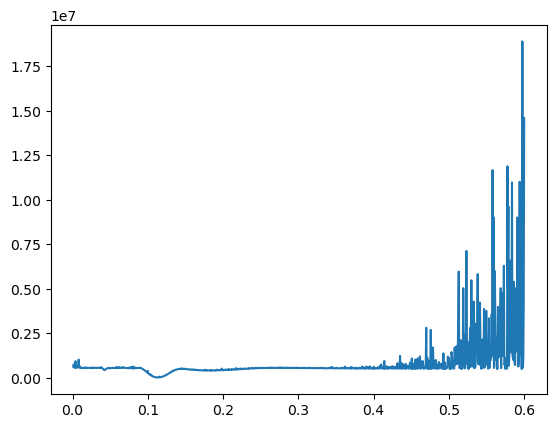

In [25]:
#plotting the period vs Chi^2
binned_t, binned_f, binned_err = binning_detrending_data(50)
p, c, power, betas = finding_period( 0.001, 0.6, trials = 1000, time = binned_t, flux = binned_f, error = binned_err) 
plt.plot(p, c)


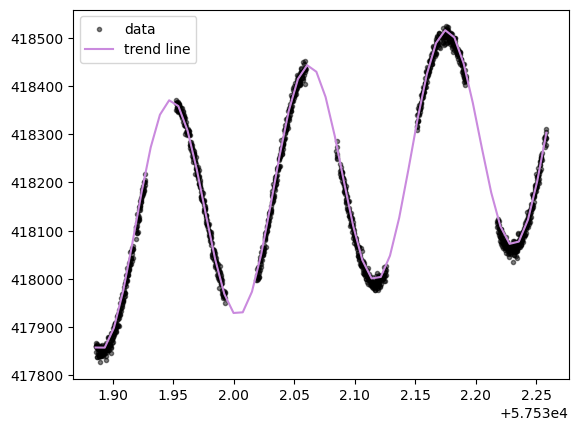

In [26]:
binned_t, binned_f, binned_err = binning_detrending_data(5)
p, c, power, betas = finding_period( 0.001, 0.6, trials = 1000, time = binned_t, flux = binned_f, error = binned_err)


index = np.argmin(c)

t_trend = np.linspace(min(detrending_data['time']), max(detrending_data['time']))

detrend_flux = using_ABCD_to_flux(t_trend , betas[index], P = p[index])

plt.scatter(detrending_data['time'], detrending_data['flux'], color = 'k', marker = '.', 
                label = 'data', alpha =0.5)

plt.plot(t_trend , detrend_flux , color = colors[0], 
                label = 'trend line', alpha =1)

plt.legend()

In [45]:
#calculating the root mean square at different bin sized
bins = np.linspace(1, 100, dtype=int)
rms = np.full(len(bins), np.nan)
rms_theory = np.full(len(bins), np.nan)

for i in range(len(bins)):
    binned_t, binned_f, binned_err = binning_detrending_data(bins[i])
    #modeling a given bin size at various periods
    p, c, power, betas = finding_period( 0.001, 0.6, trials = 1000, time = binned_t, 
                                        flux = binned_f, error = binned_err) 
    index =  np.argmin(c)
    #choosing fit with the smallest chi^2
    detrend_flux = using_ABCD_to_flux(detrending_data['time'] , betas[index], P = p[index])
    residual2 = (detrend_flux - detrending_data['flux'])**2
    rms[i] = np.sqrt(np.sum(residual2) / len(detrending_data['flux']) )
    #calculating the root mean square of this fit
    




## this next part was unsucessful 

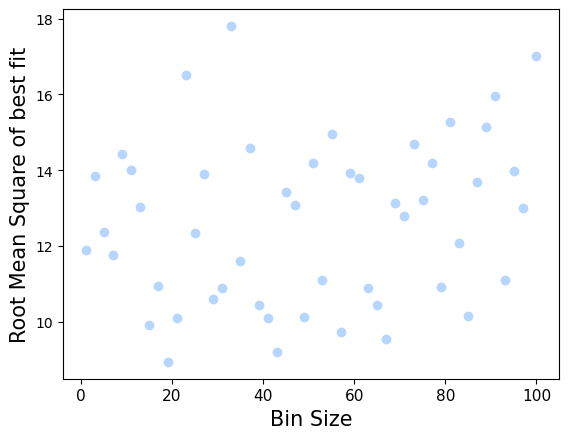

In [47]:
plt.scatter(bins, rms, color = colors[2])
#plt.scatter(19, min(rms), color = colors[3], marker = 'x', label = "smallest RMS")
#plt.legend()
#plt.ylim(0,500)
plotting("", "Bin Size", 'Root Mean Square of best fit', show = False)
#plt.savefig('RMS.pdf')

In [1188]:
#best bin for fit is 19 getting the Beta and period at this bin
best_bin = 19 #bins[np.argmin(rms)] 

binned_t, binned_f, binned_err = binning_detrending_data(best_bin)
periods, chi2s, power, betas = finding_period( 0.001, 0.6, trials = 1000, time = binned_t, 
                                        flux = binned_f, error = binned_err)
best_beta =  betas[np.argmin(chi2s)] 
best_period = periods[np.argmin(chi2s)] 

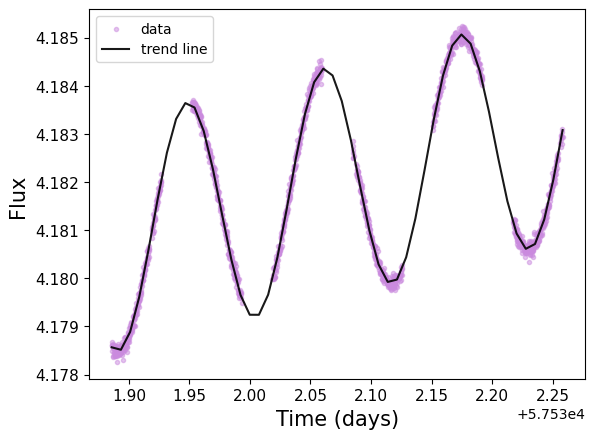

In [1411]:
t_trend = np.linspace(min(detrending_data['time']), max(detrending_data['time']))

detrend_flux = using_ABCD_to_flux(t_trend , best_beta, P = best_period)

plt.scatter(detrending_data['time'], detrending_data['flux']/10**5, color = colors[0], marker = '.', 
                label = 'data', alpha =0.5)

plt.plot(t_trend , detrend_flux/10**5 , color = 'k', 
                label = 'trend line', alpha =.9)

plt.legend()
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.3f}'))
plotting('', 'Time (days)', 'Flux ', show = False)
plt.savefig('detrend_fit.pdf')


histogram of residuals show normal distribution, divide by error 

In [3]:
from scipy import stats
num_bins = 25

residual = using_ABCD_to_flux(detrending_data['time'] , best_beta, P = best_period) - detrending_data['flux']
residual = residual / detrending_data['fluxerr']
plt.hist(residual, bins = num_bins, facecolor= colors[1], alpha=0.5, label= 'residual flux')


N = len(residual)
y = np.linspace(-4, 4, 1000)
x = stats.norm.rvs(size=N)
bin_width = (residual.max() - residual.min()) / num_bins
plt.plot(y, stats.norm.pdf(y) * N * bin_width, label = 'normal fit', color = colors[3])
plt.legend()
plotting('', 'normalized residual', '', show = False)
plt.savefig('hist_resid.pdf')



NameError: name 'using_ABCD_to_flux' is not defined

In [1195]:
cleaned_data_with_transits = data[data['e+o'] == 0]['time', 'flux', 'fluxerr']

In [1196]:
#detrending data using best fit determined above
detrend_data = Table()
detrend_data['time'] = cleaned_data_with_transits['time']
trend_of_flux = using_ABCD_to_flux(cleaned_data_with_transits['time'] , best_beta, P = best_period)
detrend_data['normalized flux'] = cleaned_data_with_transits['flux'] / trend_of_flux
detrend_data['transit'] = data[data['e+o'] == 0]['transit']
detrend_data['normalized fluxerr'] = detrend_data['normalized flux'] * np.sqrt((binned_err[0]/trend_of_flux)**2 + 
                                    (cleaned_data_with_transits['fluxerr']/cleaned_data_with_transits['flux'])**2)



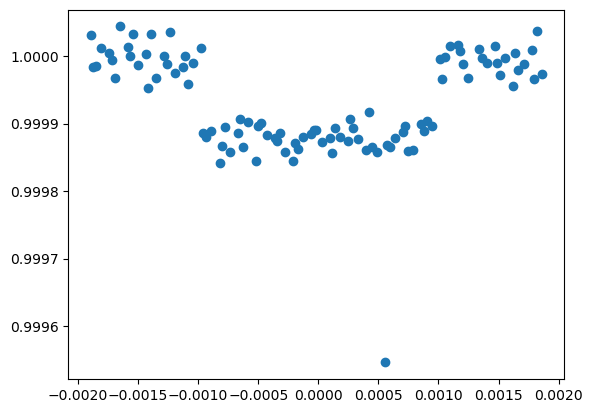

In [1314]:
#stacking tranists plus some on either side
eclipse1_plus = np.array([t0 - duration, t0 + duration])
eclipses_plus = [eclipse1_plus + (eclip_period * i) for i in range(7)]



stacked_transits = Table(names = ['time', 'normalized flux', 'normalized fluxerr', 'transit'])

for i in range(len(detrend_data)):
    for j in  range(len(eclipses_plus)):
        if eclipses_plus[j][0] <= detrend_data['time'][i] <=  eclipses_plus[j][1]:
            adj_time =  detrend_data['time'][i] - (eclip_period * j) - t0
            stacked_transits.add_row([adj_time, detrend_data['normalized flux'][i],detrend_data['normalized fluxerr'][i], detrend_data['transit'][i]])



#sorting by time 
stacked_transits.sort(['time', 'normalized flux', 'normalized fluxerr' ]) # ordering numerically 

plt.scatter(stacked_transits['time'], stacked_transits['normalized flux'])





In [1315]:
# can see outlier in data not deleted due to masking of transits 
index_of_t_outlier = np.argmin( stacked_transits['normalized flux'])
dist_to_1 = (1 - stacked_transits[index_of_t_outlier]['normalized flux']) / stacked_transits[index_of_t_outlier]['normalized fluxerr']
# is 20 errors from 1 and thus is being deleted
if dist_to_1>20:   #if statement to insure nothing is accidentially removed
     stacked_transits.remove_row(index_of_t_outlier)


In [1489]:
#getting average and standard deviation of depth
transit_depth = np.mean(stacked_transits[stacked_transits['transit'] == 1]['normalized flux'])
transit_depth_err = np.std(stacked_transits[stacked_transits['transit'] == 1]['normalized flux'])
modeled_transit = np.ones(len(stacked_transits['time']))
for i in range(len(stacked_transits['time'])):
    if abs(stacked_transits['time'][i]) < 0.5 * duration:
        modeled_transit[i] = transit_depth

In [1490]:
print(transit_depth, transit_depth_err)

0.9998792286851373 1.747553176981024e-05


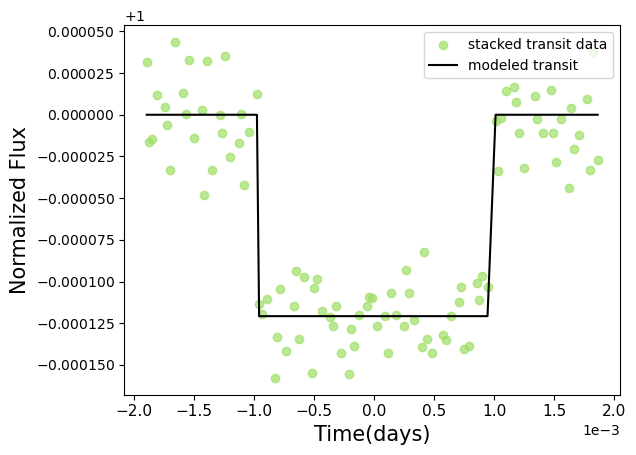

In [1493]:
#plotting depth as a piecewise function
plt.scatter(stacked_transits['time'], 
            stacked_transits['normalized flux'], alpha = 0.7,
            label = 'stacked transit data', color = colors[1])
plt.plot(stacked_transits['time'], 
         modeled_transit, label = 'modeled transit',
        color = 'k')
plt.legend(loc = 'upper right')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.gca().ticklabel_format(useMathText=True, axis='y')

plotting('', 'Time(days)', 'Normalized Flux', show = False)
plt.savefig('transit.pdf')